In [23]:
import pandas as pd
import seaborn as sns
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as ss
from urllib.parse import urlencode 
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg
import matplotlib as plt
%matplotlib inline

# Вариант 1

---
### Задание 1
<i>Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).<i>
    
---

In [3]:
# Считаем csv-файл с яндекс диска и положим их в переменные. Столбцы с датами сразу переведем в нужный тип данных.
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_auth = 'https://disk.yandex.ru/d/r7y4CxZge4mgiQ'
public_key_reg = 'https://disk.yandex.ru/d/T6XECcdmPrPXOg'
# получаем url 
final_url_auth = base_url + urlencode(dict(public_key=public_key_auth))
final_url_reg = base_url + urlencode(dict(public_key=public_key_reg))
response_auth, response_reg = requests.get(final_url_auth),  requests.get(final_url_reg)
download_url_auth, download_url_reg = response_auth.json()['href'], response_reg.json()['href']  
# загружаем файл в df 
download_response_auth, download_response_reg  = requests.get(download_url_auth), requests.get(download_url_reg)
auth_data = pd.read_csv(download_url_auth, sep=';')
reg_data = pd.read_csv(download_url_reg, sep=';')

In [4]:
auth_data['auth_time'] = pd.to_datetime(auth_data.auth_ts, unit='s')
reg_data['reg_time'] = pd.to_datetime(reg_data.reg_ts, unit='s')
# Создадим столбцы с датой и временем

Предварительный анализ данных:
- Всего зарегистрировано 1000000 юзеров. 
- В датасете reg_data представлены даты регистрации для каждого uid. 
- Даты регистрации находятся в диапазоне от <b>1998-11-18</b> 09:43:43 до  <b>2020-09-23</b> 15:17:24
- В датасете auth_data представлены даты каждого входа юзеров в игру
- Даты входа в игру находятся в диапазоне от <b>1998-11-18</b> 09:43:43 до  <b>2020-09-23</b> 15:17:24
- Пропущенные значения отсутствуют
- Дубликаты отсутствуют

In [5]:
# Создадим единый дф
df = auth_data.merge(reg_data, on='uid', how='left').rename(columns={'uid': 'user_id'})

In [6]:
df['reg_day'] = df.reg_time.dt.to_period('D')  # Создаем колонку с днём регистрации для каждой строчки
df['auth_day'] = df.auth_time.dt.to_period('D')  # Создаем колонку с днями авторизаций для каждой строчки

In [7]:
# Пользователей поделим на когорты по дню регистрации
cohorts = df\
    .groupby(['reg_day', 'auth_day'])\
    .agg({'user_id': 'count'})\
    .reset_index()\
    .rename(columns={'user_id': 'users_count'})

Будем считать отвалившимися пользователями тех, кто не заходил в игру более 14 дней с момента установки. Таким образом, retention будем смотреть только для первых 15 дней. 

Для примера retention посчитаем только для актуальных данных (актуальными будем считать данные начиная с 2020 г.).

Для примера retention будем считать по дням, начиная со дня регистрации пользователя только по понедельникам (каждая когорта - пользователи, зарегистрировавшиеся в очередной понедельник).

In [24]:
cohorts['days_passed'] = cohorts['auth_day'].astype('int64') - cohorts['reg_day'].astype('int64') 
cohorts_pivot = cohorts\
    .query('days_passed <=15 and reg_day>"2020-01-01" and reg_day.dt.weekday == 0')\
    .pivot_table(index='reg_day', columns='days_passed', values='users_count')
cohort_sizes = cohorts_pivot.iloc[:, 0]
retention = cohorts_pivot.divide(cohort_sizes, axis=0)
retention.style.background_gradient()

days_passed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
reg_day,,,,,,,,,,,,,,,,
2020-01-06,1.000000,0.028972,0.044860,0.049533,0.038318,0.046729,0.066355,0.058879,0.052336,0.050467,0.053271,0.049533,0.040187,0.040187,0.045794,0.049533
2020-01-13,1.000000,0.019391,0.044321,0.048015,0.057248,0.057248,0.069252,0.062789,0.029548,0.069252,0.049861,0.047091,0.043398,0.061865,0.048015,0.048938
2020-01-20,1.000000,0.016423,0.038321,0.050182,0.062956,0.064781,0.071168,0.063869,0.047445,0.058394,0.046533,0.053832,0.053832,0.046533,0.045620,0.051095
2020-01-27,1.000000,0.017148,0.035199,0.046931,0.054152,0.051444,0.074007,0.053249,0.043321,0.061372,0.042419,0.048736,0.047834,0.045126,0.037004,0.047834
2020-02-03,1.000000,0.016949,0.043711,0.046387,0.056200,0.062444,0.082070,0.049063,0.049955,0.051740,0.061552,0.049063,0.049063,0.051740,0.052632,0.056200
2020-02-10,1.000000,0.020282,0.036155,0.044092,0.045855,0.047619,0.071429,0.066138,0.036155,0.041446,0.054674,0.038801,0.051146,0.055556,0.041446,0.041446
2020-02-17,1.000000,0.026155,0.037489,0.042720,0.049695,0.056670,0.062772,0.069747,0.050567,0.050567,0.052310,0.047079,0.063644,0.044464,0.043592,0.054926
2020-02-24,1.000000,0.022414,0.039655,0.041379,0.045690,0.071552,0.066379,0.062931,0.043966,0.052586,0.060345,0.041379,0.052586,0.048276,0.048276,0.044828
2020-03-02,1.000000,0.013640,0.036658,0.041773,0.049446,0.067349,0.060529,0.063086,0.048593,0.052856,0.051151,0.057118,0.049446,0.051151,0.036658,0.039216


<Axes: title={'center': 'Retention Heatmap'}, xlabel='Days Passed', ylabel='Registration Day'>

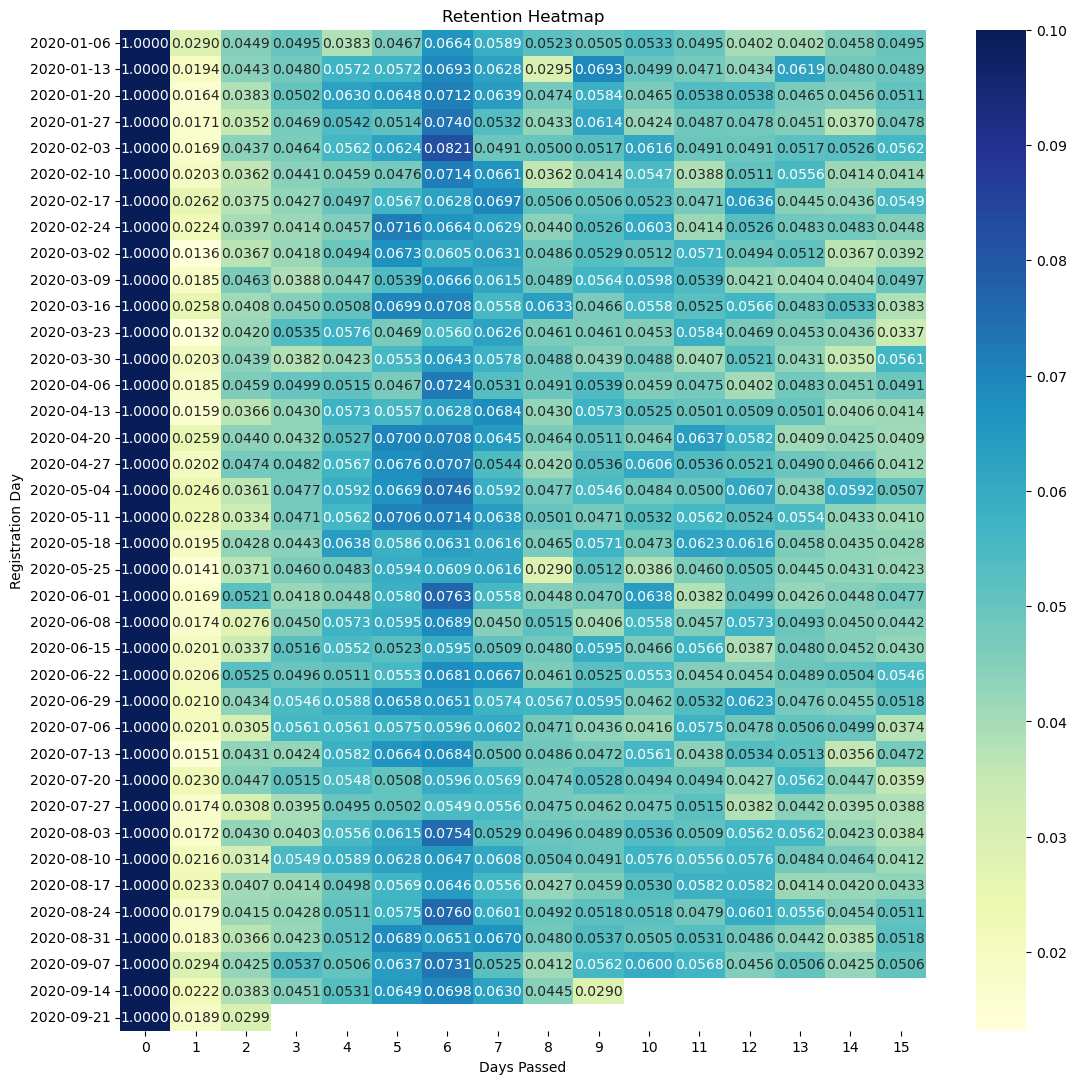

In [45]:
# Дополнительно визуализируем через seaborn для нормального отображения в github
plt.figure(figsize = (13, 13))
heatmap = sns.heatmap(retention, annot=True, vmax = 0.1, cmap="YlGnBu", fmt = ".4f")
heatmap.set_title('Retention Heatmap')
heatmap.set_xlabel('Days Passed')
heatmap.set_ylabel('Registration Day')
heatmap

## Итоговая функция.
#### Принимает на вход ссылки на данные, требуемый период обзора и день недели. <br> На выходе функция выдаёт heatmap-таблицу Retention.

- Параметр period должен быть кортежем из 2 дат в  формате "YYYY-MM-DD", где первая дата - начало периода, за который нужно узнать retention, а вторая - его конец (например ("2019-03-06", "2020-01-08").
- Параметр weekday (день недели) должен быть в формате числа от 0 до 6, где 0 - понедельник, а 6 - воскресенье. <br>Возможно выбрать несколько дней недели, в том числе все.

In [46]:
def retention_func(reg_data_link, auth_data_link, period, weekday):
    """    Итоговая функция.
    Принимает на вход: 
     1) reg_data_link - данные о регистрациях, auth_data_link - данные об авторизациях,
     2) period: требуемый к обзору период. 
     Параметр period должен быть кортежем из 2 дат в формате "YYYY-MM-DD", где первая дата - начало периода, 
     за который нужно узнать retention, а вторая - его конец (например ("2019-03-06", "2020-01-08").
     3) weekday: день недели
     Параметр weekday (день недели) должен быть в формате числа от 0 до 6, где 0 - понедельник, а 6 - воскресенье.
     Возможно выбрать несколько дней недели, в том числе все.
    
    На выходе функция выдаёт heatmap-таблицу Retention.
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url_auth = base_url + urlencode(dict(public_key=auth_data_link))
    final_url_reg = base_url + urlencode(dict(public_key=reg_data_link))
    response_auth, response_reg = requests.get(final_url_auth),  requests.get(final_url_reg)
    download_url_auth, download_url_reg = response_auth.json()['href'], response_reg.json()['href']  
    download_response_auth, download_response_reg  = requests.get(download_url_auth), requests.get(download_url_reg)
    auth_data = pd.read_csv(download_url_auth, sep=';')
    reg_data = pd.read_csv(download_url_reg, sep=';')
    auth_data['auth_time'] = pd.to_datetime(auth_data.auth_ts, unit='s')
    reg_data['reg_time'] = pd.to_datetime(reg_data.reg_ts, unit='s')
    df = auth_data.merge(reg_data, on='uid', how='left').rename(columns={'uid': 'user_id'})
    df['reg_day'] = df.reg_time.dt.to_period('D') 
    df['auth_day'] = df.auth_time.dt.to_period('D')
    cohorts = df\
        .groupby(['reg_day', 'auth_day'])\
        .agg({'user_id': 'count'})\
        .reset_index()\
        .rename(columns={'user_id': 'users_count'})
    cohorts['days_passed'] = cohorts['auth_day'].astype('int64') - cohorts['reg_day'].astype('int64') 
    cohorts_pivot = cohorts.query(f'days_passed <= 15 and reg_day.dt.weekday == {weekday} and\
                                  reg_day >= "{period[0]}" and\
                                  reg_day <= "{period[1]}"')\
        .pivot_table(index='reg_day', columns='days_passed', values='users_count')
    cohort_sizes = cohorts_pivot.iloc[:, 0]
    retention = cohorts_pivot.divide(cohort_sizes, axis=0)
    plt.figure(figsize = (13, 13))
    heatmap = sns.heatmap(retention, annot=True, vmax = 0.1, cmap="YlGnBu", fmt = ".4f")
    heatmap.set_title('Retention Heatmap')
    heatmap.set_xlabel('Days Passed')
    heatmap.set_ylabel('Registration Day')
    heatmap
    return (retention.style.background_gradient(), heatmap)

(<pandas.io.formats.style.Styler at 0x235a4c963b0>,
 <Axes: title={'center': 'Retention Heatmap'}, xlabel='Days Passed', ylabel='Registration Day'>)

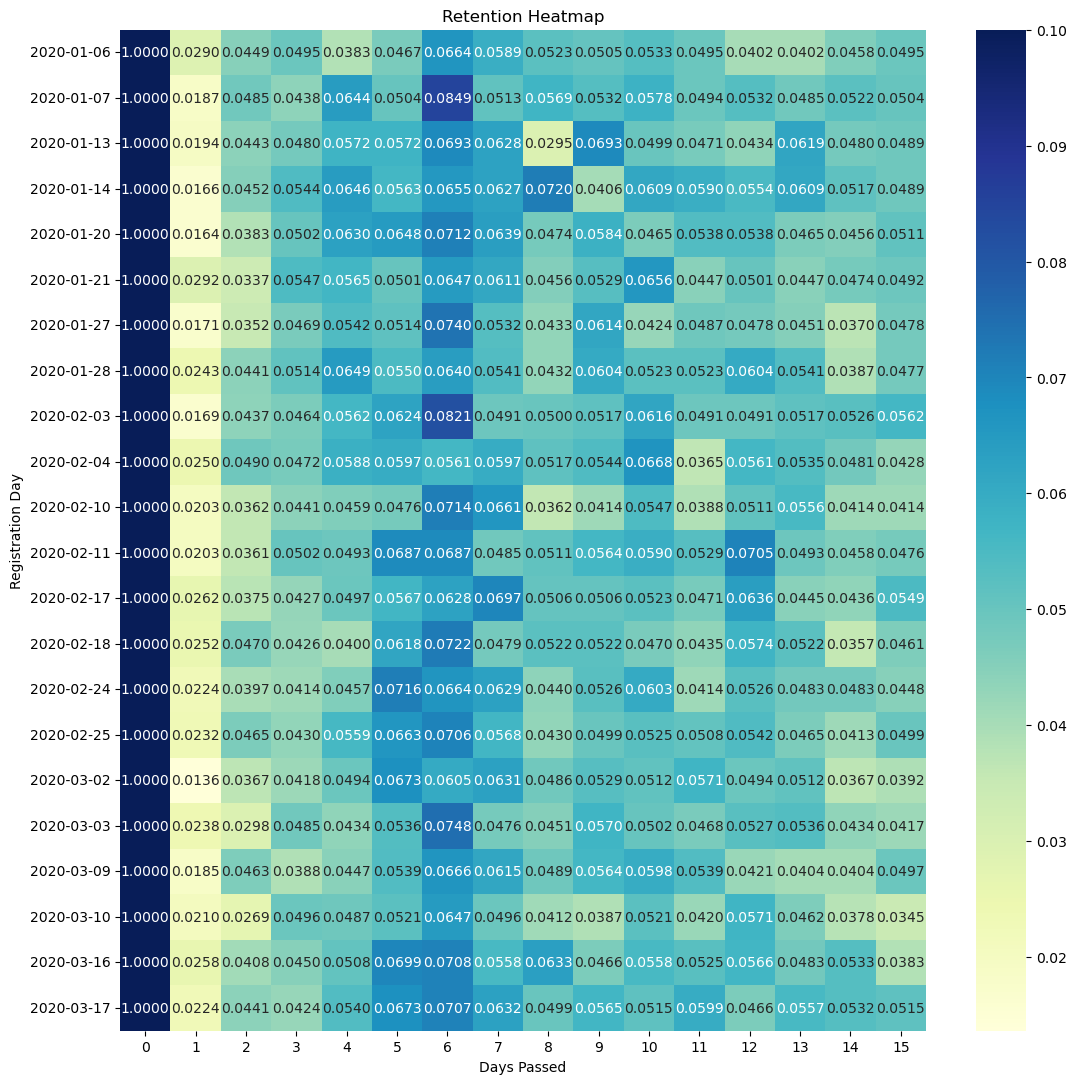

In [47]:
# Пример вызова функции
retention_func('https://disk.yandex.ru/d/T6XECcdmPrPXOg',
               'https://disk.yandex.ru/d/r7y4CxZge4mgiQ',
               ("2020-01-01", "2020-03-20"), (0, 1))

In [ ]:
#Описание функции через докстринг
print(retention_func.__doc__)

    Итоговая функция.
    Принимает на вход: 
     1) reg_data_link - данные о регистрациях, auth_data_link - данные об авторизациях,
     2) period: требуемый к обзору период. 
     Параметр period должен быть кортежем из 2 дат в формате "YYYY-MM-DD", где первая дата - начало периода, 
     за который нужно узнать retention, а вторая - его конец (например ("2019-03-06", "2020-01-08").
     3) weekday: день недели
     Параметр weekday (день недели) должен быть в формате числа от 0 до 6, где 0 - понедельник, а 6 - воскресенье.
     Возможно выбрать несколько дней недели, в том числе все.
    
    На выходе функция выдаёт heatmap-таблицу Retention.
    


---
### Задание 2
<i>Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?<i>

---

In [16]:
# Считаем csv-файл с яндекс диска и положим их в переменные. Столбцы с датами сразу переведем в нужный тип данных.
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href'] 
# загружаем файл в df 
download_response = requests.get(download_url) 
ab_test = pd.read_csv(download_url, sep=';')

Нулевые, пропущенные, дублирующиеся значения в датасете отсутствуют.
Взглянем на данные по выручке на графике.

<Axes: xlabel='revenue', ylabel='Count'>

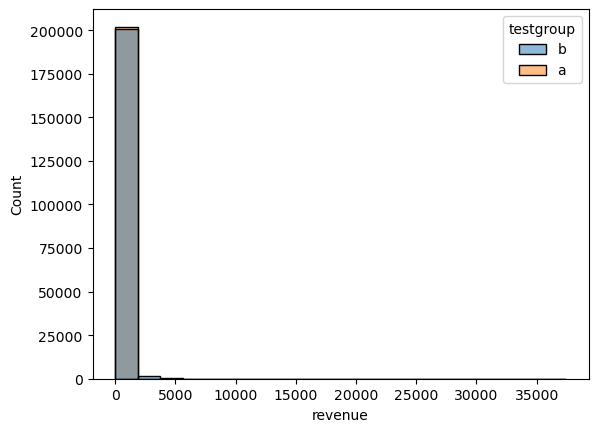

In [17]:
sns.histplot(data=ab_test, x='revenue', hue='testgroup')

В обоих группах явно отсутствует нормальное распределение, большая часть игроков не является платящими, как и было сказано в условиях задачи

Теперь взглянем на распределение, отфильтровав те строки, где покупки не было совершено:

<Axes: xlabel='revenue', ylabel='Count'>

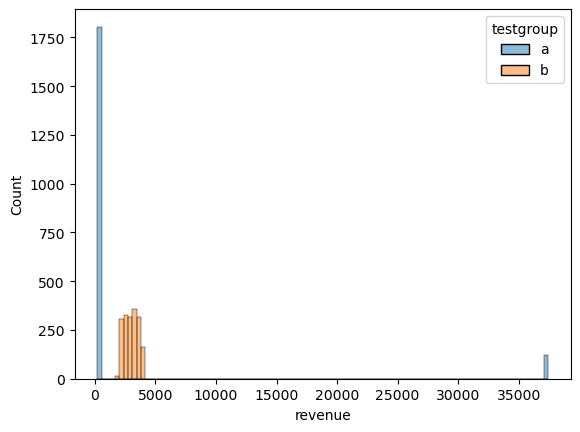

In [18]:
sns.histplot(data = ab_test.query('revenue!= 0'), x = 'revenue', hue = 'testgroup')

Дополнительно удостоверимся в отсутствии нормального распределения платящих пользователей тестом Шапиро-Уилкса и всех пользователей,
взглянув на QQ-plots 

ShapiroResult(statistic=0.2667924165725708, pvalue=0.0)
ShapiroResult(statistic=0.9583134651184082, pvalue=2.4929213770979496e-22)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


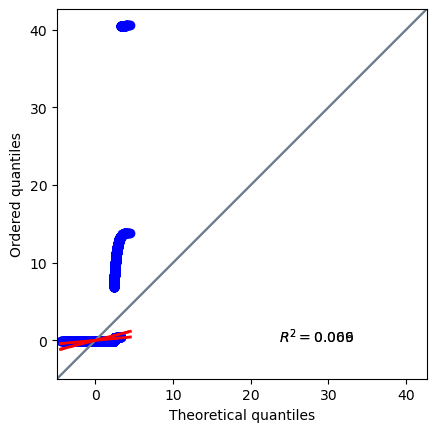

In [19]:
print(ss.shapiro(ab_test.query('revenue != 0 and testgroup == "a"').revenue))
print(ss.shapiro(ab_test.query('revenue != 0 and testgroup == "b"').revenue))
print(pg.qqplot(ab_test.query(' testgroup == "a"').revenue))
print(pg.qqplot(ab_test.query(' testgroup == "b"').revenue))

Обе группы всех пользователей не имеют нормального распределения выручки, по результатам анализа qq-plot. <br>
Обе группы платящих пользователей не имеют нормального распределения выручки. Контрольная группа а имеет 2 ярко выраженные моды, то есть распределение не является унимодальным. <br>
- В контрольной группе а 2 моды: не считая 0: 200-400 и 37293-37433.
- В тестовой группе b 1 мода: ровно от 2000 до 4000.

Так как в датасете нет информаций отдельно по всем чекам, а только по пользователям, то мы не можем посмотреть на средний чек, но можем сравнить ARPU и ARPPU.   

Проанализируем и сравним:
1. ARPU
2. ARPPU
3. Медианную выручку на платящего пользователя
4. Долю платящих юзеров

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной

Так как распределения не соответствуют требованиям для применения t-теста: обе группы не имеют нормального распределения, то будут применяться иные критерии

Вследствие того, что в распределениях присутствуют большие выбросы, простой bootstrap на сырых данных не дает возможность объективно сравнить ARPU, так как доверительный интервал ARPU тестовой группы попадает полностью в  доверительный интервал ARPU контрольной группы.

### Анализ ARPU

Для начала применим критерий Левена, чтобы определить равенство дисперсий в обоих группах. В качестве параметра зададим функцию median, рекомендованную для перекошенных распределений.

In [20]:
ss.levene(ab_test.query('testgroup == "a"').revenue, ab_test.query('testgroup == "b"').revenue, center='median')

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

По результатам критерия Левена мы не может отклонить нулевую гипотезу, то есть дисперсии выручки на пользователя в обеих группах статистически значимо не отличаются

Для сравнения ARPU применим двухвыборочный тест Колмогорова-Смирнова

In [21]:
ss.ks_2samp(ab_test.query('testgroup == "a"').revenue, 
            ab_test.query('testgroup == "b"').revenue,
            alternative='greater')

KstestResult(statistic=0.00829763478652823, pvalue=8.806334495991114e-07, statistic_location=400, statistic_sign=1)

Результаты теста показывают, что распределения в выборках статистически значимо отличаются друг от друга. Вероятность случайно взять из одной выборки более высокое значение, чем из другой больше 50%
По результатам теста можно заявить, что в группе b значение ARPU значимо выше, чем в контрольной группе

### Анализ ARPPU
Теперь взглянем на ARPPU:
Для начала, посчитаем ARPPU, не используя статистические методы:

In [22]:
print(ab_test.query('revenue != 0 and testgroup == "a"').revenue.mean(), 'ARPPU контрольной группы')
print(ab_test.query('revenue != 0 and testgroup == "b"').revenue.mean(), 'ARPPU тестовой группы')
print("На", (((ab_test.query('revenue != 0 and testgroup == "b"').revenue.mean()
             - ab_test.query('revenue != 0 and testgroup == "a"').revenue.mean())
             / ab_test.query('revenue != 0 and testgroup == "a"').revenue.mean())*100)
              .round(4), '% ARPPU тестовой группы выше контрольной')

2663.9984439834025 ARPPU контрольной группы
3003.6581717451522 ARPPU тестовой группы
На 12.75 % ARPPU тестовой группы выше контрольной


ARPPU для группы a составил 2664, а для группы b: 3004 $. Таким образом, ARPPU для группы b выше на 12,75%

Для статистической проверки утверждения сформулируем нулевую гипотезу: "ARPPU в тестовой и контрольной группе не различаются статистически значимо"

Для сравнения ARPPU применим bootstrap-тест (так как распределения имеют разную форму, критерий Крускалла-Уоллиса неприменим).

Так как в группе b имеется довольно большое количество выбросов (высоких значений), является целесообразным прологарифмировать значения revenue с целью сделать распределение более сглаженным.
Взглянем на получившееся распределение:

<Axes: xlabel='log_revenue', ylabel='Count'>

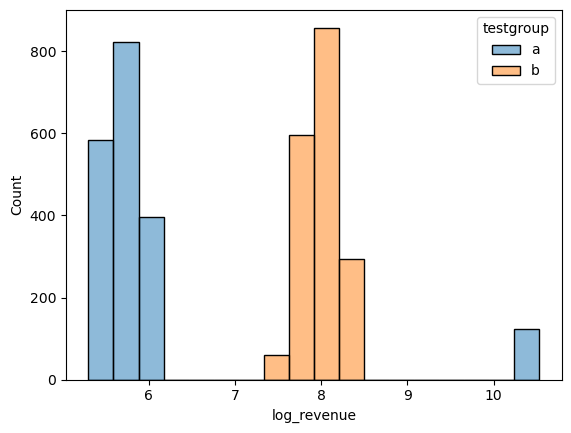

In [23]:
ab_test['log_revenue'] = np.log(ab_test.query('revenue != 0').revenue)
sns.histplot(data=ab_test.dropna(), x='log_revenue', hue='testgroup')

In [24]:
#  Не забудем дропнуть нулевые значения, ставшие NaN-ами.
print(ss.bootstrap((ab_test.dropna().query('testgroup == "a"').log_revenue, ), np.mean))
print(ss.bootstrap((ab_test.dropna().query('testgroup == "b"').log_revenue, ), np.mean))

BootstrapResult(confidence_interval=ConfidenceInterval(low=5.952144747263285, high=6.058176795593193), bootstrap_distribution=array([5.98427176, 6.01124092, 5.98444056, ..., 6.02233777, 5.9627219 ,
       6.01697153]), standard_error=0.027101088026841972)
BootstrapResult(confidence_interval=ConfidenceInterval(low=7.97976170932744, high=7.997990067484466), bootstrap_distribution=array([7.9974787 , 7.98341689, 7.98075575, ..., 7.98869944, 7.98284909,
       7.98784885]), standard_error=0.004663690735145819)


По результатам bootstrap-теста по прологарифирмированным данным, доверительный интервал среднего тестовой группы b выше доверительного интервала контрольной группы a, таким образом можно утверждать, что ARPPU тестовой группы значимо выше ARPPU контрольной группы.

<br>
<br>
Дополнительно сравним медиану выручки на платящего пользователя по сырым данным:

In [25]:
revenue_a = ab_test.query('revenue != 0 and testgroup == "a"').revenue
revenue_b = ab_test.query('revenue != 0 and testgroup == "b"').revenue

In [26]:
print(ss.bootstrap((revenue_a, ), np.median, method='percentile'))
print(ss.bootstrap((revenue_b, ), np.median, method='percentile'))

BootstrapResult(confidence_interval=ConfidenceInterval(low=308.0, high=315.0), bootstrap_distribution=array([312., 310., 313., ..., 311., 311., 313.]), standard_error=1.7951437889250124)
BootstrapResult(confidence_interval=ConfidenceInterval(low=2970.0, high=3072.0), bootstrap_distribution=array([2966., 2979., 3052., ..., 2986., 2952., 3063.]), standard_error=26.344728587260228)


По результатам проведенных тестов, доверительный интервал медианы группы a (контрольной) значительно ниже доверительного интервала медианы тестовой группы.



Сравним долю платящих юзеров по группам:

In [27]:
print(revenue_a.count() / ab_test.query('testgroup == "a"').revenue.count(), 
      ': Доля платящих юзеров в контрольной группе')
print(revenue_b.count() / ab_test.query('testgroup == "b"').revenue.count(), 
      ': Доля платящих юзеров в тестовой группе')

0.009539690157988749 : Доля платящих юзеров в контрольной группе
0.008906235351586593 : Доля платящих юзеров в тестовой группе


In [28]:
#  Вспомогательная колонка
ab_test['is_paying'] = ab_test['revenue'] > 0

<Axes: xlabel='testgroup', ylabel='count'>

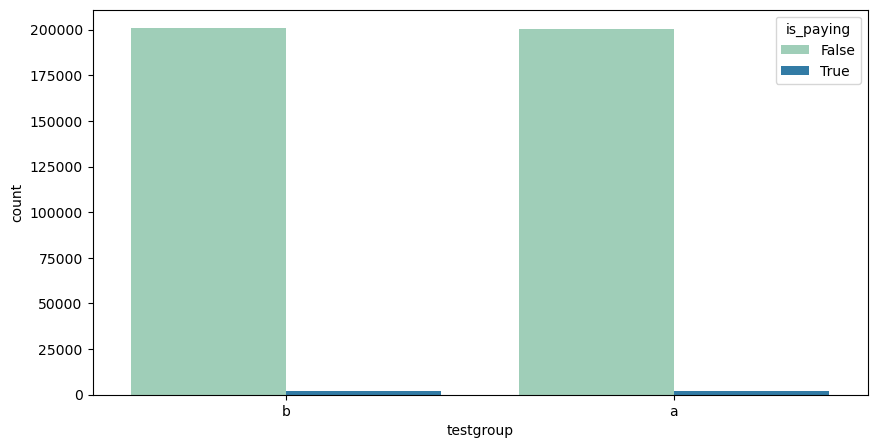

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(data=ab_test, x='testgroup', hue='is_paying', palette='YlGnBu')

По результатам предварительного подсчета, доля платящих юзеров в контрольной группе несколько выше доли платящих юзеров в тестовой группе. Проверим это статистически, нулевая гипотеза "Нулевая гипотеза - доля платящих юзеров статистически значимо не различается в обоих группах"

In [30]:
stat, pval = proportions_ztest([revenue_a.count(), revenue_b.count()], [ab_test.query('testgroup == "a"')
                                                                        .revenue.count(),
                                                                        ab_test.query('testgroup == "b"')
                                                                        .revenue.count()])
print(pval)

0.035028524642854865


Так как p-value составляет 0.035, можно утверждать, что в генеральной совокупности доля платящих юзеров в тестовой и контрольной группых статистически значимо различается (доля платящих юзеров выше в контрольной группе)

Таким образом, 

- Распределения в выборках статистически значимо отличаются друг от друга. Вероятность случайно взять из одной выборки более высокое значение, чем из другой больше 50% 

- ARPU тестовой группы значимо выше ARPU контрольной группы.

- ARPPU тестовой группы значимо выше ARPPU контрольной группы.

- Медиана выручки на платящего пользователя тестовой группы статистически значимо и значительно выше медианы контрольной группы.

- При этом, доля платящих юзеров в тестовой и контрольной группых статистически значимо различается (доля платящих юзеров выше в контрольной группе)

#### На основании полученных данных можно заключить, что тестовая группа является предпочтительной


Стоит заметить, что дизайн A/B-теста, по результатам которого получены данные, вероятно, был нарушен, так как в тестовой и контрольной группе находятся абсолютно непересекающиеся сегменты пользователей по выручке. 
Для проверки данного утверждения необходимо видеть, как было проведено сплитование, как был проведен A/A-тест, а также в чем заключался эксперимент. 
Если это утверждение верно, потребуется повторное сплитование и перезапуск эксперимента

---
### Задание  3
<i>В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?<i>

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

--- 



Так как игры такого типа, как правило, относятся к категории free-to-play (то есть, играть можно бесплатно, но также возможно приобретать внутриигровые предметы и большинство пользователей относятся к неплатящим, но при этом платящее меньшинство генерирует большую часть прибыли), то необходимо просегментировать активных пользователей на следующие сегменты:
1. Платящие игроки, участвовашие в событии, прошедшие его и получившие бонусы
2. Платящие игроки, участвовашие в событии и не прошедшие его
3. Платящие активные игроки, не участвовашие в событии
4. Неплатящие игроки, участвовашие в событии, прошедшие его и получившие бонусы
5. Неплатящие игроки, участвовашие в событии и не прошедшие его
6. Неплатящие активные игроки, не участвовавшие в событии

Для выделенных сегментов после завершения события нужно:
Более приоритетные метрики:
1. Провести RFM анализ для платящих игроков сегменты (4-6).
2. Подсчитать retention пользователей
3. Подсчитать MAU и DAU
4. Для сегментов 1, 2, 3 необходимо подсчитать изменение понедельной выручки на игрока (ARPU) до, в ходе и после завершения события
5. сегментов 4, 5, 6 необходимо подсчитать конверсию из неплатящих игроков в платящие.

Менее приоритетные метрики:
4. Время, за которое были пройдены все уровни
5. Время, проведенное в игре в день
6. Время прохождения одного уровня
7. Доля игроков, приступивших к прохождению события, но не завершивших его


Общие метрики: 
Более приоритетно:
- подсчитать рост выручки в ходе события и в течение 10 дней после него, сравнить с выручкой в те периоды, когда тематических событий не проводилось и с предыдущими событиями
- Доля юзеров, вернувшихся к игре в результате проведения события (падение churn rate).
Менее приоритетно:
- Доля юзеров, принявших участие в событии и сравнить с предыдущими событиями
- Доля юзеров, получивших бонусы в событии и сравнить с предыдущими событиями
- Количество полученных бонусов на пользователя и сравнить с предыдущими событиями



<br>
<br>
В случае изменения механики событий, к набору анализируемых метрик следует добавить:
1 метрику: долю игроков, бросивших прохождение события после наступления отката
 Также, следует изменить сегментацию пользователей и добавить 2 дополнительных сегмента для анализа всех остальных ранее анализировавшихся метрик:

- платящие игроки, бросившие прохождение события после наступления отката
- неплатящие игроки, бросившие прохождение события после наступления отката